In [1]:
import pandas as pd
from pathlib import Path
from getpass import getpass


from helpers_mfq import mfq_part1, mfq_part2

Consistência: 

1. ver se há spread nas respostas do mesmo foundation do MFQ
2. Rodar cronbach alpha no MFQ
3. Rodar cronbach alpha no MFV
4. Rodar regressao Medias MFQ vs media MFV

Abstract: 120 a 150 palavras

Testar EFA no MFQ

In [2]:
model = "gpt-3.5-turbo"

MFQ INFO

In [3]:
questions1 = [q for q in mfq_part1.split("\n\n")[2].split("\n") if q]
questions2 = [q for q in mfq_part2.split("\n\n")[2].split("\n") if q]

questions1_item_key = [
    ("emotionally", "harm"),
    ("treated", "fairness"),
    ("lovecountry", "ingroup"),
    ("respect", "authority"),
    ("decency", "purity"),
    ("math", None),
    ("weak", "harm"),
    ("unfairly", "fairness"),
    ("betray", "ingroup"),
    ("traditions", "authority"),
    ("disgusting", "purity"),
    ("cruel", "harm"),
    ("rights", "fairness"),
    ("loyalty", "ingroup"),
    ("chaos", "authority"),
    ("god", "purity"),
]

questions2_item_key = [
    ("compassion", "harm"),
    ("fairly", "fairness"),
    ("history", "ingroup"),
    ("kidrespect", "authority"),
    ("harmlessdg", "purity"),
    ("good", None),
    ("animal", "harm"),
    ("justice", "fairness"),
    ("family", "ingroup"),
    ("sexroles", "authority"),
    ("unnatural", "purity"),
    ("kill", "harm"),
    ("rich", "fairness"),
    ("team", "ingroup"),
    ("soldier", "authority"),
    ("chastity", "purity"),
]

Analysing data


In [4]:
from pathlib import Path
df_chat = pd.concat(
    map(pd.read_csv, Path("data/mfq").glob("*3.5-turbo*.csv")),
)

In [5]:
df_chat["math"].value_counts()

1    117
2     69
0     68
3      1
Name: math, dtype: int64

In [6]:
df_chat["good"].value_counts()

5    139
4    116
Name: good, dtype: int64

Filtering rows based on control questions - only one case was filtered out

In [7]:
df_chat.query("math < 3 and good > 2", inplace=True)

# drop cols
df_chat.drop(columns=["math", "good"], inplace=True)

# Compare before and after distributions

In [8]:
import numpy as np
def cohen_d(x,y):
        from math import sqrt
        return (np.mean(x) - np.mean(y)) / sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2.0)


def compare_subsets_distributions(df_ordered, df_randomized):
    import scipy.stats
    from scipy.stats import mannwhitneyu
    from statsmodels.stats.multitest import multipletests
    test_results = list()

    for code in df_ordered.columns:
        ordered_answers = df_ordered[code]

        randomized_answer = df_randomized[code]
        if df_randomized[str(code)].nunique() < 3 or df_ordered[str(code)].nunique() < 3:
            print(
                f"Code: {code} had {df_ordered[str(code)].nunique()} different answers when generated in order"
            )
            print(
                f"Code: {code} had {df_randomized[str(code)].nunique()} different answers when generated randomized"
            )

        test_results.append(
            (
                code,
                np.median(ordered_answers),
                scipy.stats.median_abs_deviation(ordered_answers),
                np.median(randomized_answer),
                scipy.stats.median_abs_deviation(randomized_answer),
                cohen_d(ordered_answers, randomized_answer),
                *mannwhitneyu(ordered_answers, randomized_answer),
            )
        )

    df_tests = pd.DataFrame(
        test_results,
        columns=["mfv_code", "mediana_ordered", "MAD_ordered", "mediana_randomized", "MAD_randomized", "cohen_d", "u", "p-value"],
    )
    df_tests["rejected"], df_tests["adjusted_p-value"], _, _ = multipletests(
        df_tests["p-value"],
        alpha=0.05,
        method="bonferroni"
    )
    # round adjusted p-value to 3 decimals
    df_tests["adjusted_p-value"] = df_tests["adjusted_p-value"].apply(lambda x: round(x, 4))

    df_tests["median_dif"] = df_tests["mediana_ordered"] - df_tests["mediana_randomized"]
    return df_tests

In [9]:
before_after_comparison = compare_subsets_distributions(
    df_chat.query("condition == 'before'").drop(columns=["id", "condition"]),
    df_chat.query("condition == 'after'").drop(columns=["id", "condition"]),
)

Code: treated had 1 different answers when generated in order
Code: treated had 2 different answers when generated randomized
Code: weak had 2 different answers when generated in order
Code: weak had 3 different answers when generated randomized
Code: unfairly had 2 different answers when generated in order
Code: unfairly had 3 different answers when generated randomized
Code: cruel had 2 different answers when generated in order
Code: cruel had 2 different answers when generated randomized
Code: loyalty had 2 different answers when generated in order
Code: loyalty had 3 different answers when generated randomized
Code: fairly had 2 different answers when generated in order
Code: fairly had 2 different answers when generated randomized
Code: history had 2 different answers when generated in order
Code: history had 2 different answers when generated randomized
Code: kidrespect had 2 different answers when generated in order
Code: kidrespect had 2 different answers when generated randomi

In [10]:
before_after_comparison["rejected"].value_counts()

False    75
True     23
Name: rejected, dtype: int64

In [11]:
before_after_comparison.query("rejected == True")

,mfv_code,mediana_ordered,MAD_ordered,mediana_randomized,MAD_randomized,cohen_d,u,p-value,rejected,adjusted_p-value,median_dif
2,lovecountry,2.0,0.0,2.0,0.0,0.593993,10305.0,4.861563e-07,True,0.0000,0.0
4,decency,4.0,0.0,4.0,0.0,0.558365,10086.5,4.692484e-06,True,0.0005,0.0
8,traditions,4.0,0.0,4.0,0.0,0.506564,10043.5,4.772525e-05,True,0.0047,0.0
9,disgusting,4.0,0.0,3.0,1.0,0.967193,11730.0,2.827444e-13,True,0.0000,1.0
11,rights,4.0,0.0,4.0,0.0,-0.815448,5475.5,1.048224e-09,True,0.0000,0.0
14,god,4.0,0.0,4.0,1.0,-0.581969,5445.0,7.281305e-07,True,0.0001,0.0
19,harmlessdg,3.0,0.0,3.0,0.0,0.475360,9850.5,2.390521e-04,True,0.0234,0.0
21,justice,5.0,0.0,5.0,0.0,-0.497187,6239.5,1.208119e-04,True,0.0118,0.0
22,family,4.0,0.0,4.0,0.0,0.452385,9737.5,3.303391e-04,True,0.0324,0.0
23,sexroles,3.0,0.0,3.0,0.0,0.552060,10109.0,1.047888e-05,True,0.0010,0.0


In [12]:
before_after_comparison.query("rejected == True")["median_dif"].describe()

count    23.000000
mean     -0.086957
std       0.417029
min      -1.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000
Name: median_dif, dtype: float64

In [13]:
# make a dictionary with the second value of elements in questions1_item_key as keys and the first value as values. Repeated keys should generate a list of values
questions_dict = {}
for i in questions1_item_key + questions2_item_key:
    if i[1] is None:
        continue
    if i[1] in questions_dict:
        questions_dict[i[1]].append(i[0])
    else:
        questions_dict[i[1]] = [i[0]]



# Cronbach for MFQ foundations

Create dataframe for comparative analysis

In [14]:
df = pd.DataFrame()

df["id"] = df_chat["id"]
df["condition"] = df_chat["condition"]

In [15]:
from pingouin import cronbach_alpha

Intervals represent 95% CI

In [16]:
for foundation, questions in questions_dict.items():
    df[f"MFQ_{foundation.lower()}"] = df_chat[questions].mean(axis=1)
    print(f"Cronbach for {foundation.upper()}:", cronbach_alpha(df_chat[questions]))
    # cronbach para before
    print(
        "Before condition:",
        cronbach_alpha(df_chat.query("condition == 'before'")[questions])
    )
    # after
    print(
        "After condition:",
        cronbach_alpha(df_chat.query("condition == 'after'")[questions])
    )

Cronbach for HARM: (0.48770601098725286, array([0.384, 0.579]))
Before condition: (0.5216182619505026, array([0.381, 0.639]))
After condition: (0.4723611958511291, array([0.315, 0.604]))
Cronbach for FAIRNESS: (0.48617440295158804, array([0.382, 0.578]))
Before condition: (0.2368163265306124, array([0.013, 0.424]))
After condition: (0.542077505159367, array([0.405, 0.656]))
Cronbach for INGROUP: (0.422390931381061, array([0.305, 0.526]))
Before condition: (0.27404991491775404, array([0.061, 0.452]))
After condition: (0.49899639096257475, array([0.35 , 0.624]))
Cronbach for AUTHORITY: (0.34241774629508837, array([0.209, 0.46 ]))
Before condition: (0.3663433559650824, array([0.181, 0.522]))
After condition: (0.3422494974076818, array([0.146, 0.506]))
Cronbach for PURITY: (0.5049998429697564, array([0.404, 0.594]))
Before condition: (0.4340952661849287, array([0.268, 0.573]))
After condition: (0.5903218743157433, array([0.468, 0.692]))


Generate histogram for each foundation

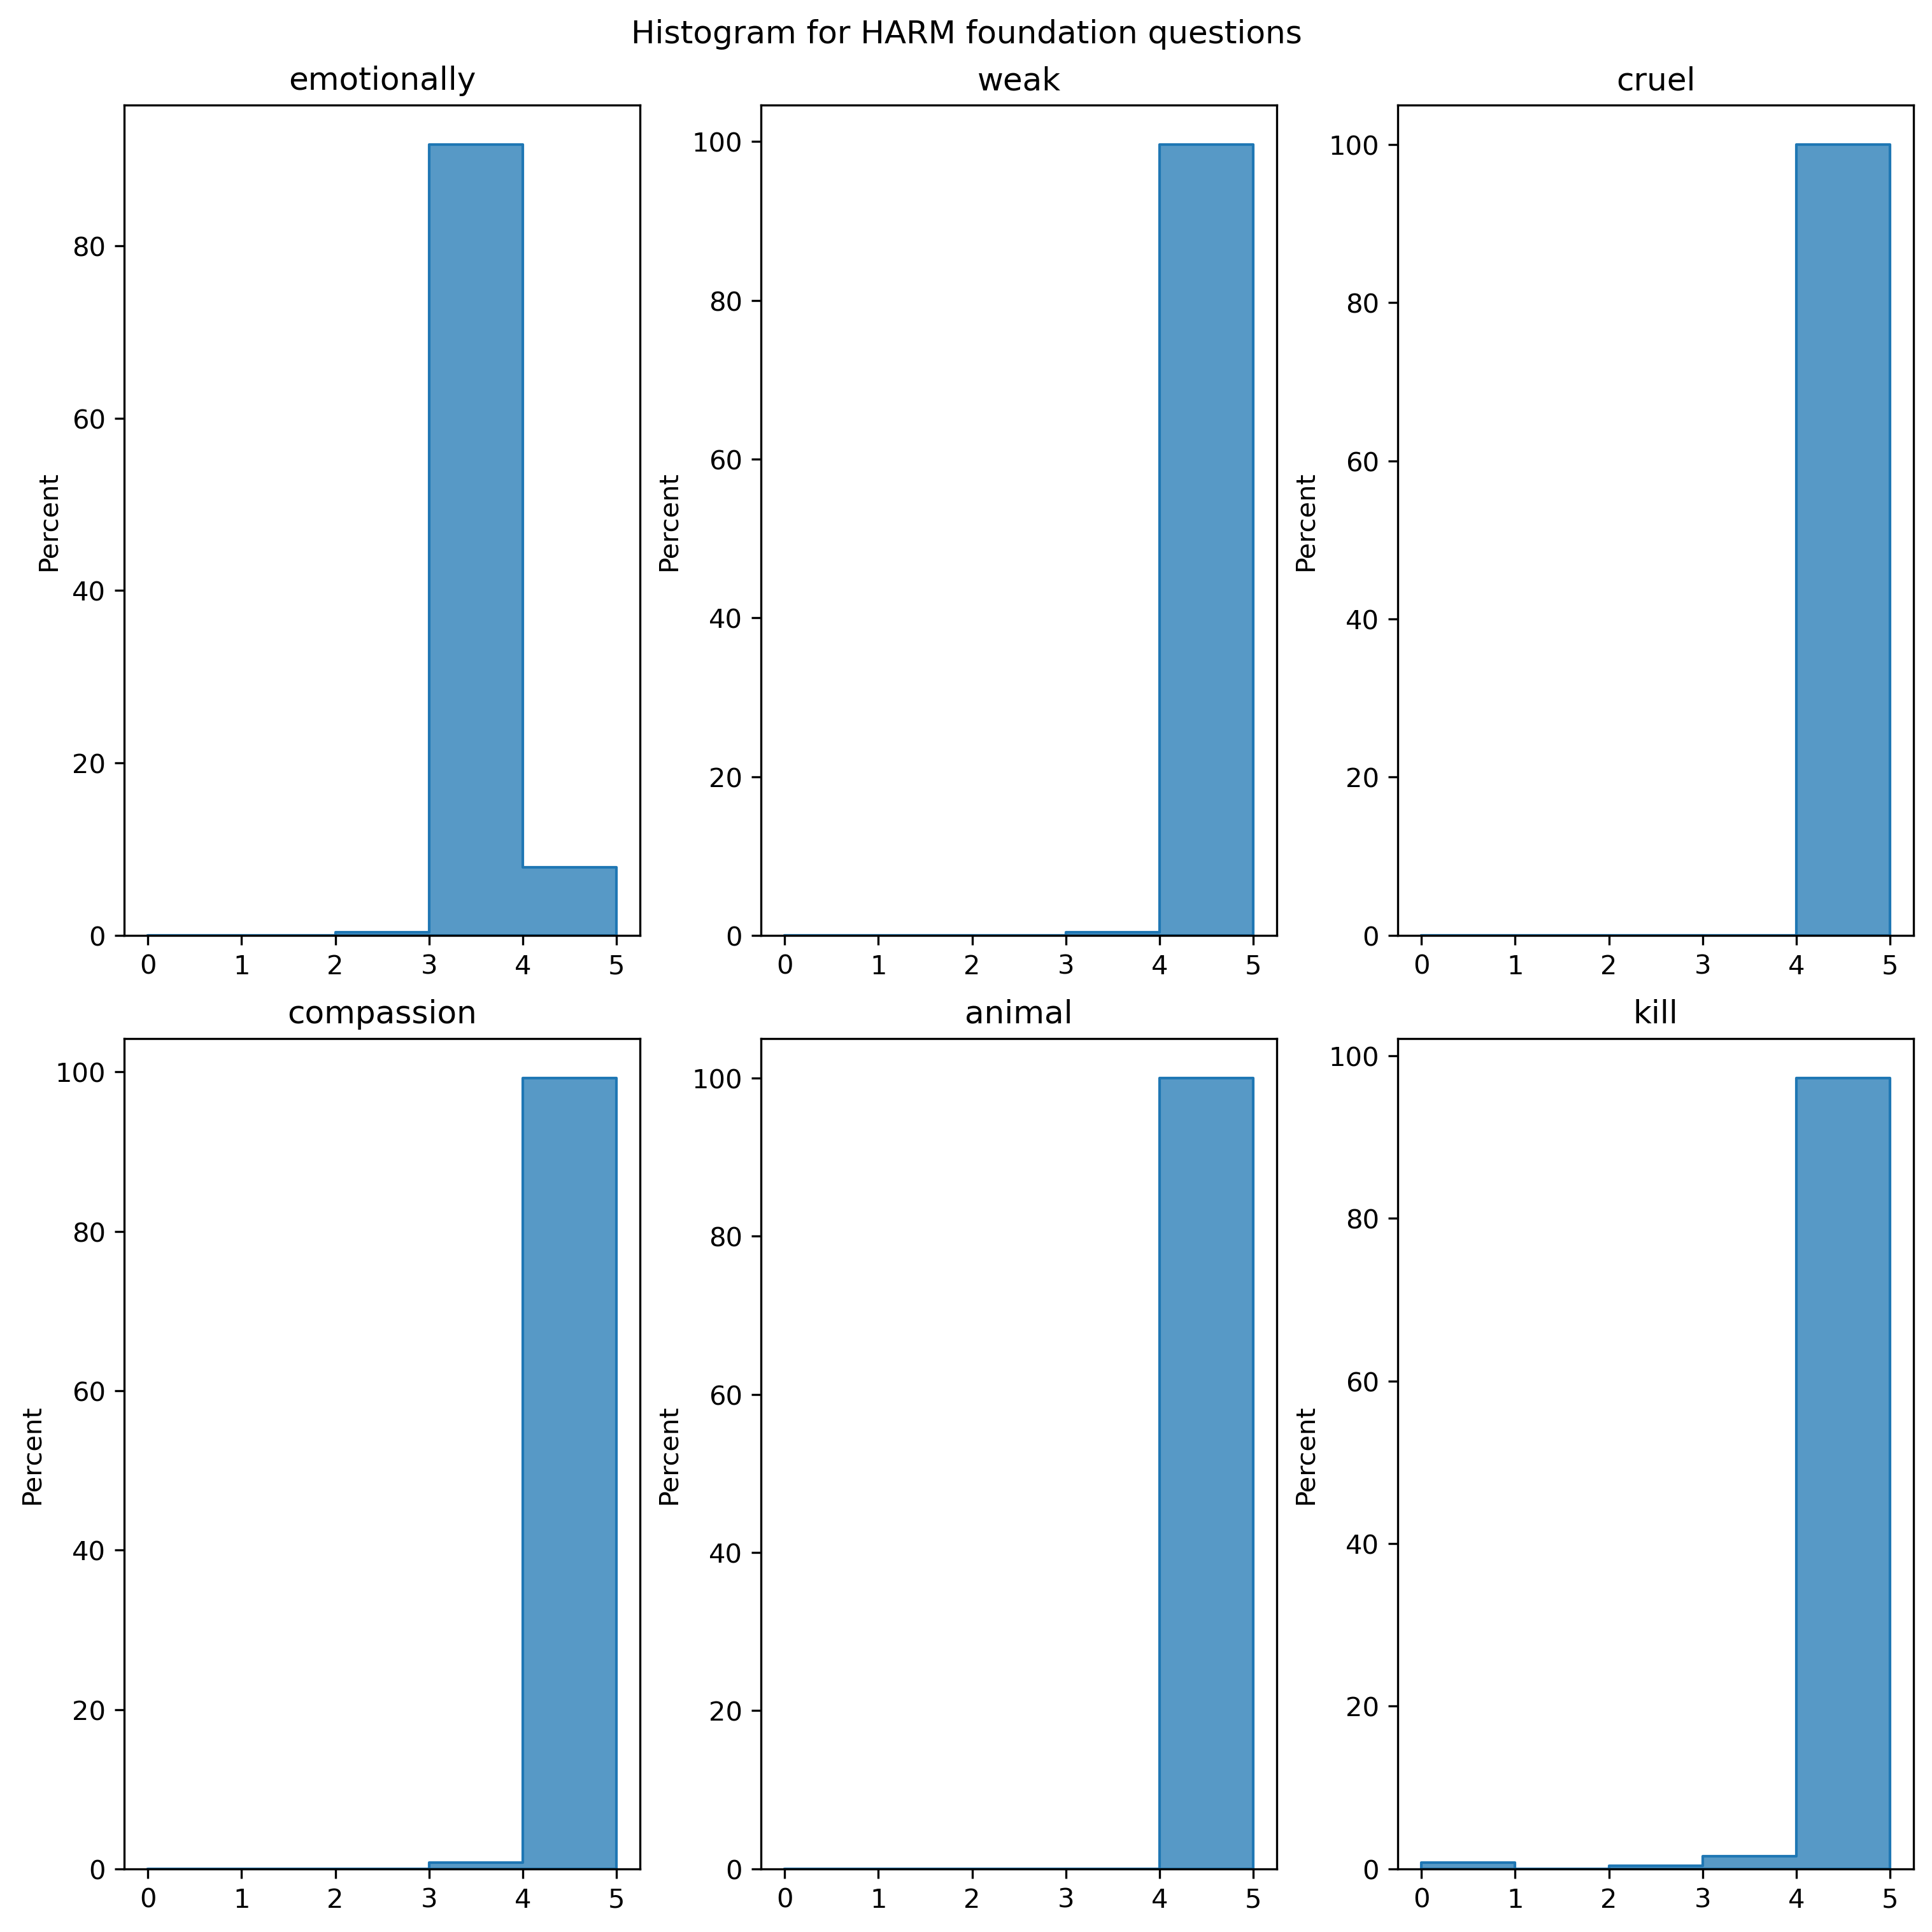

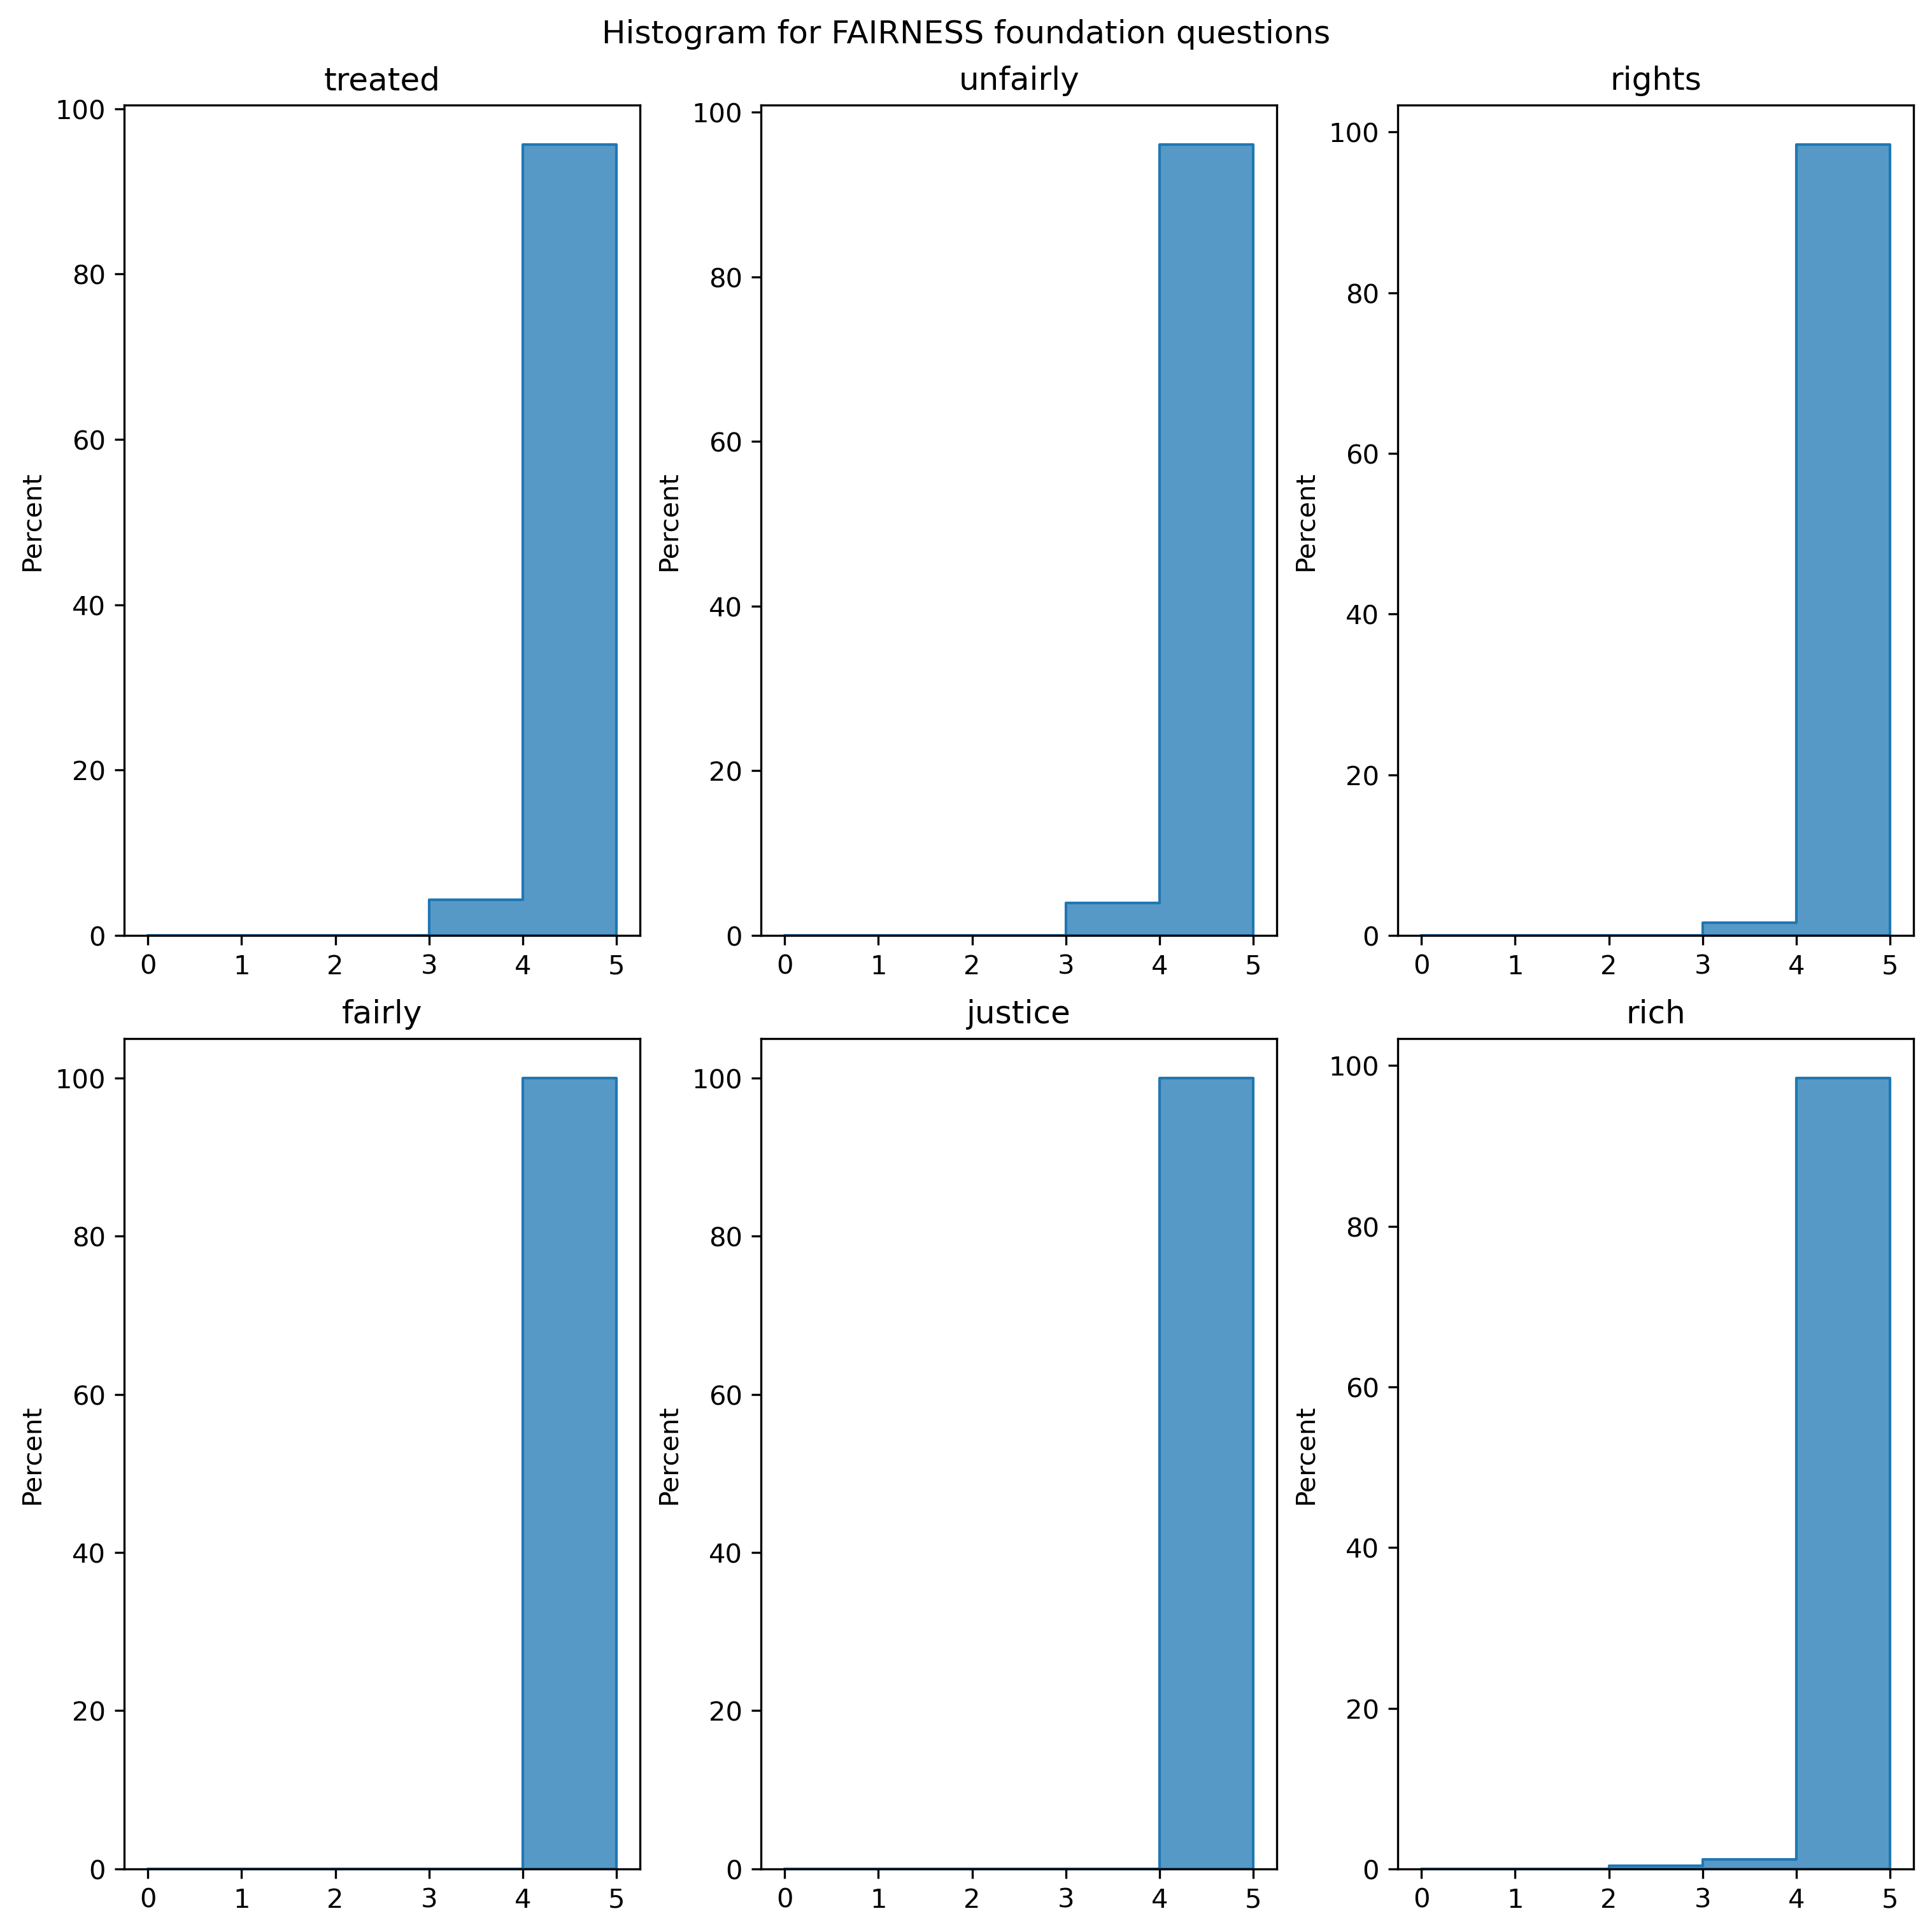

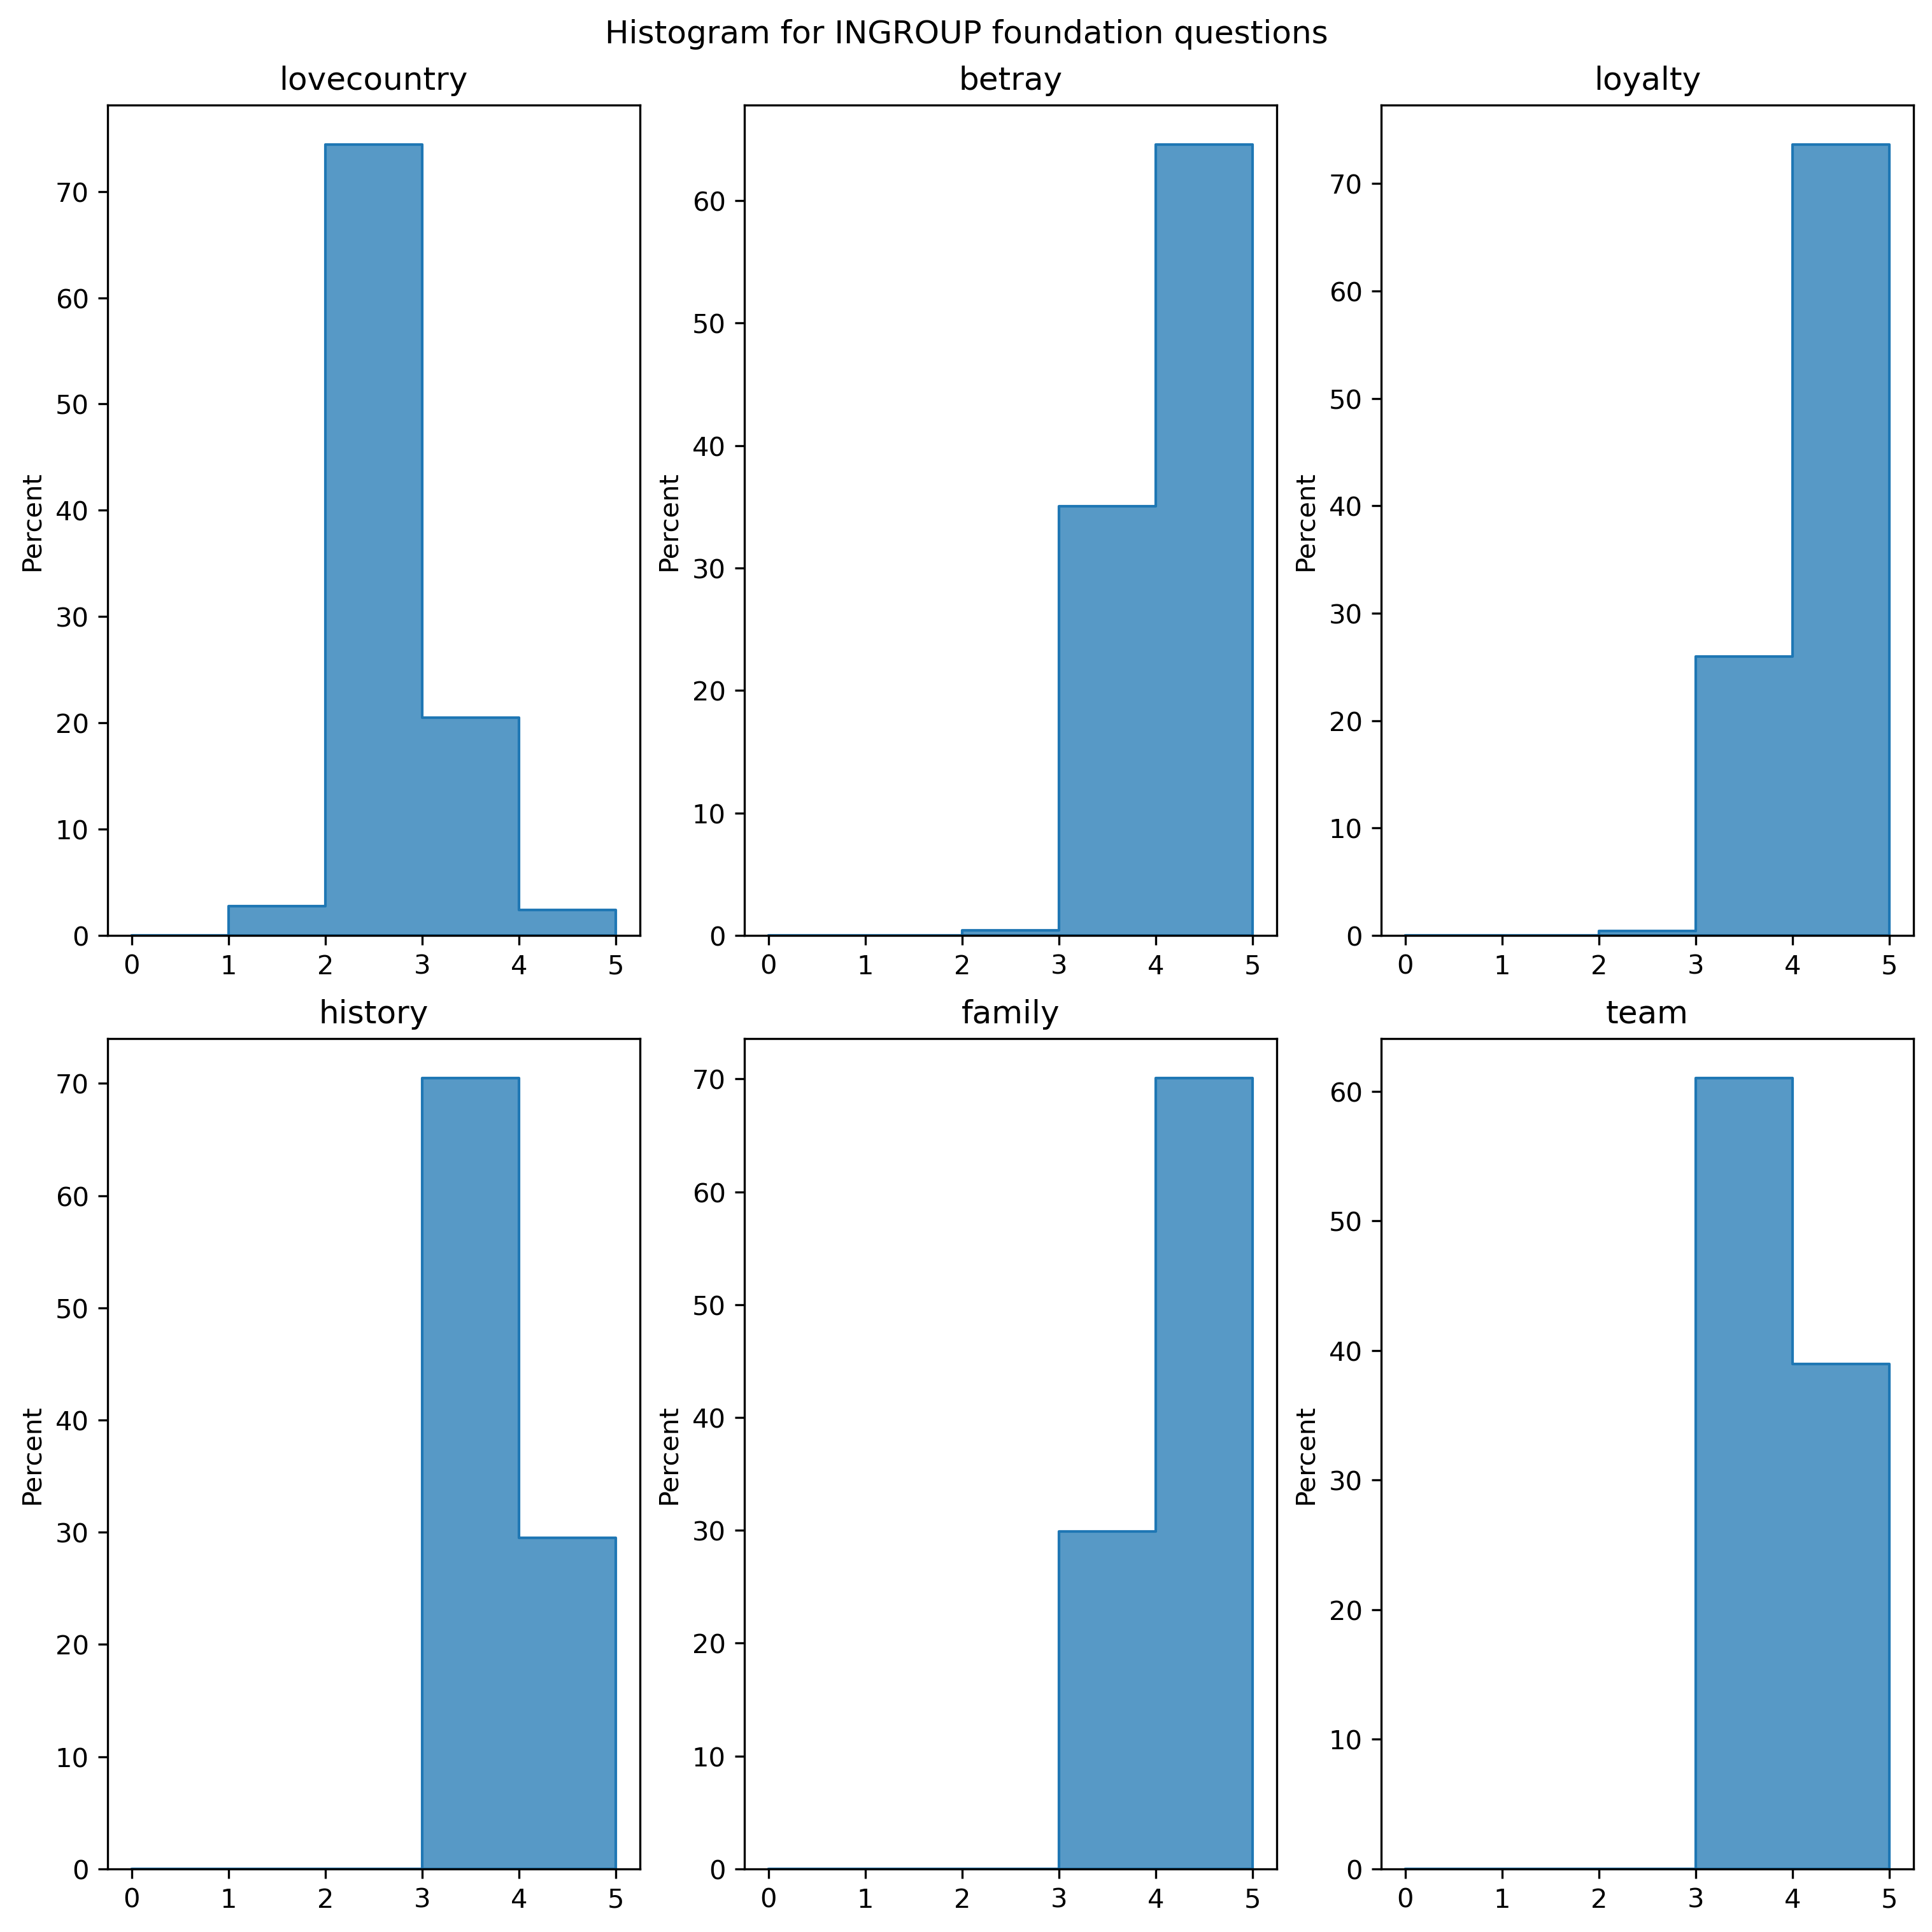

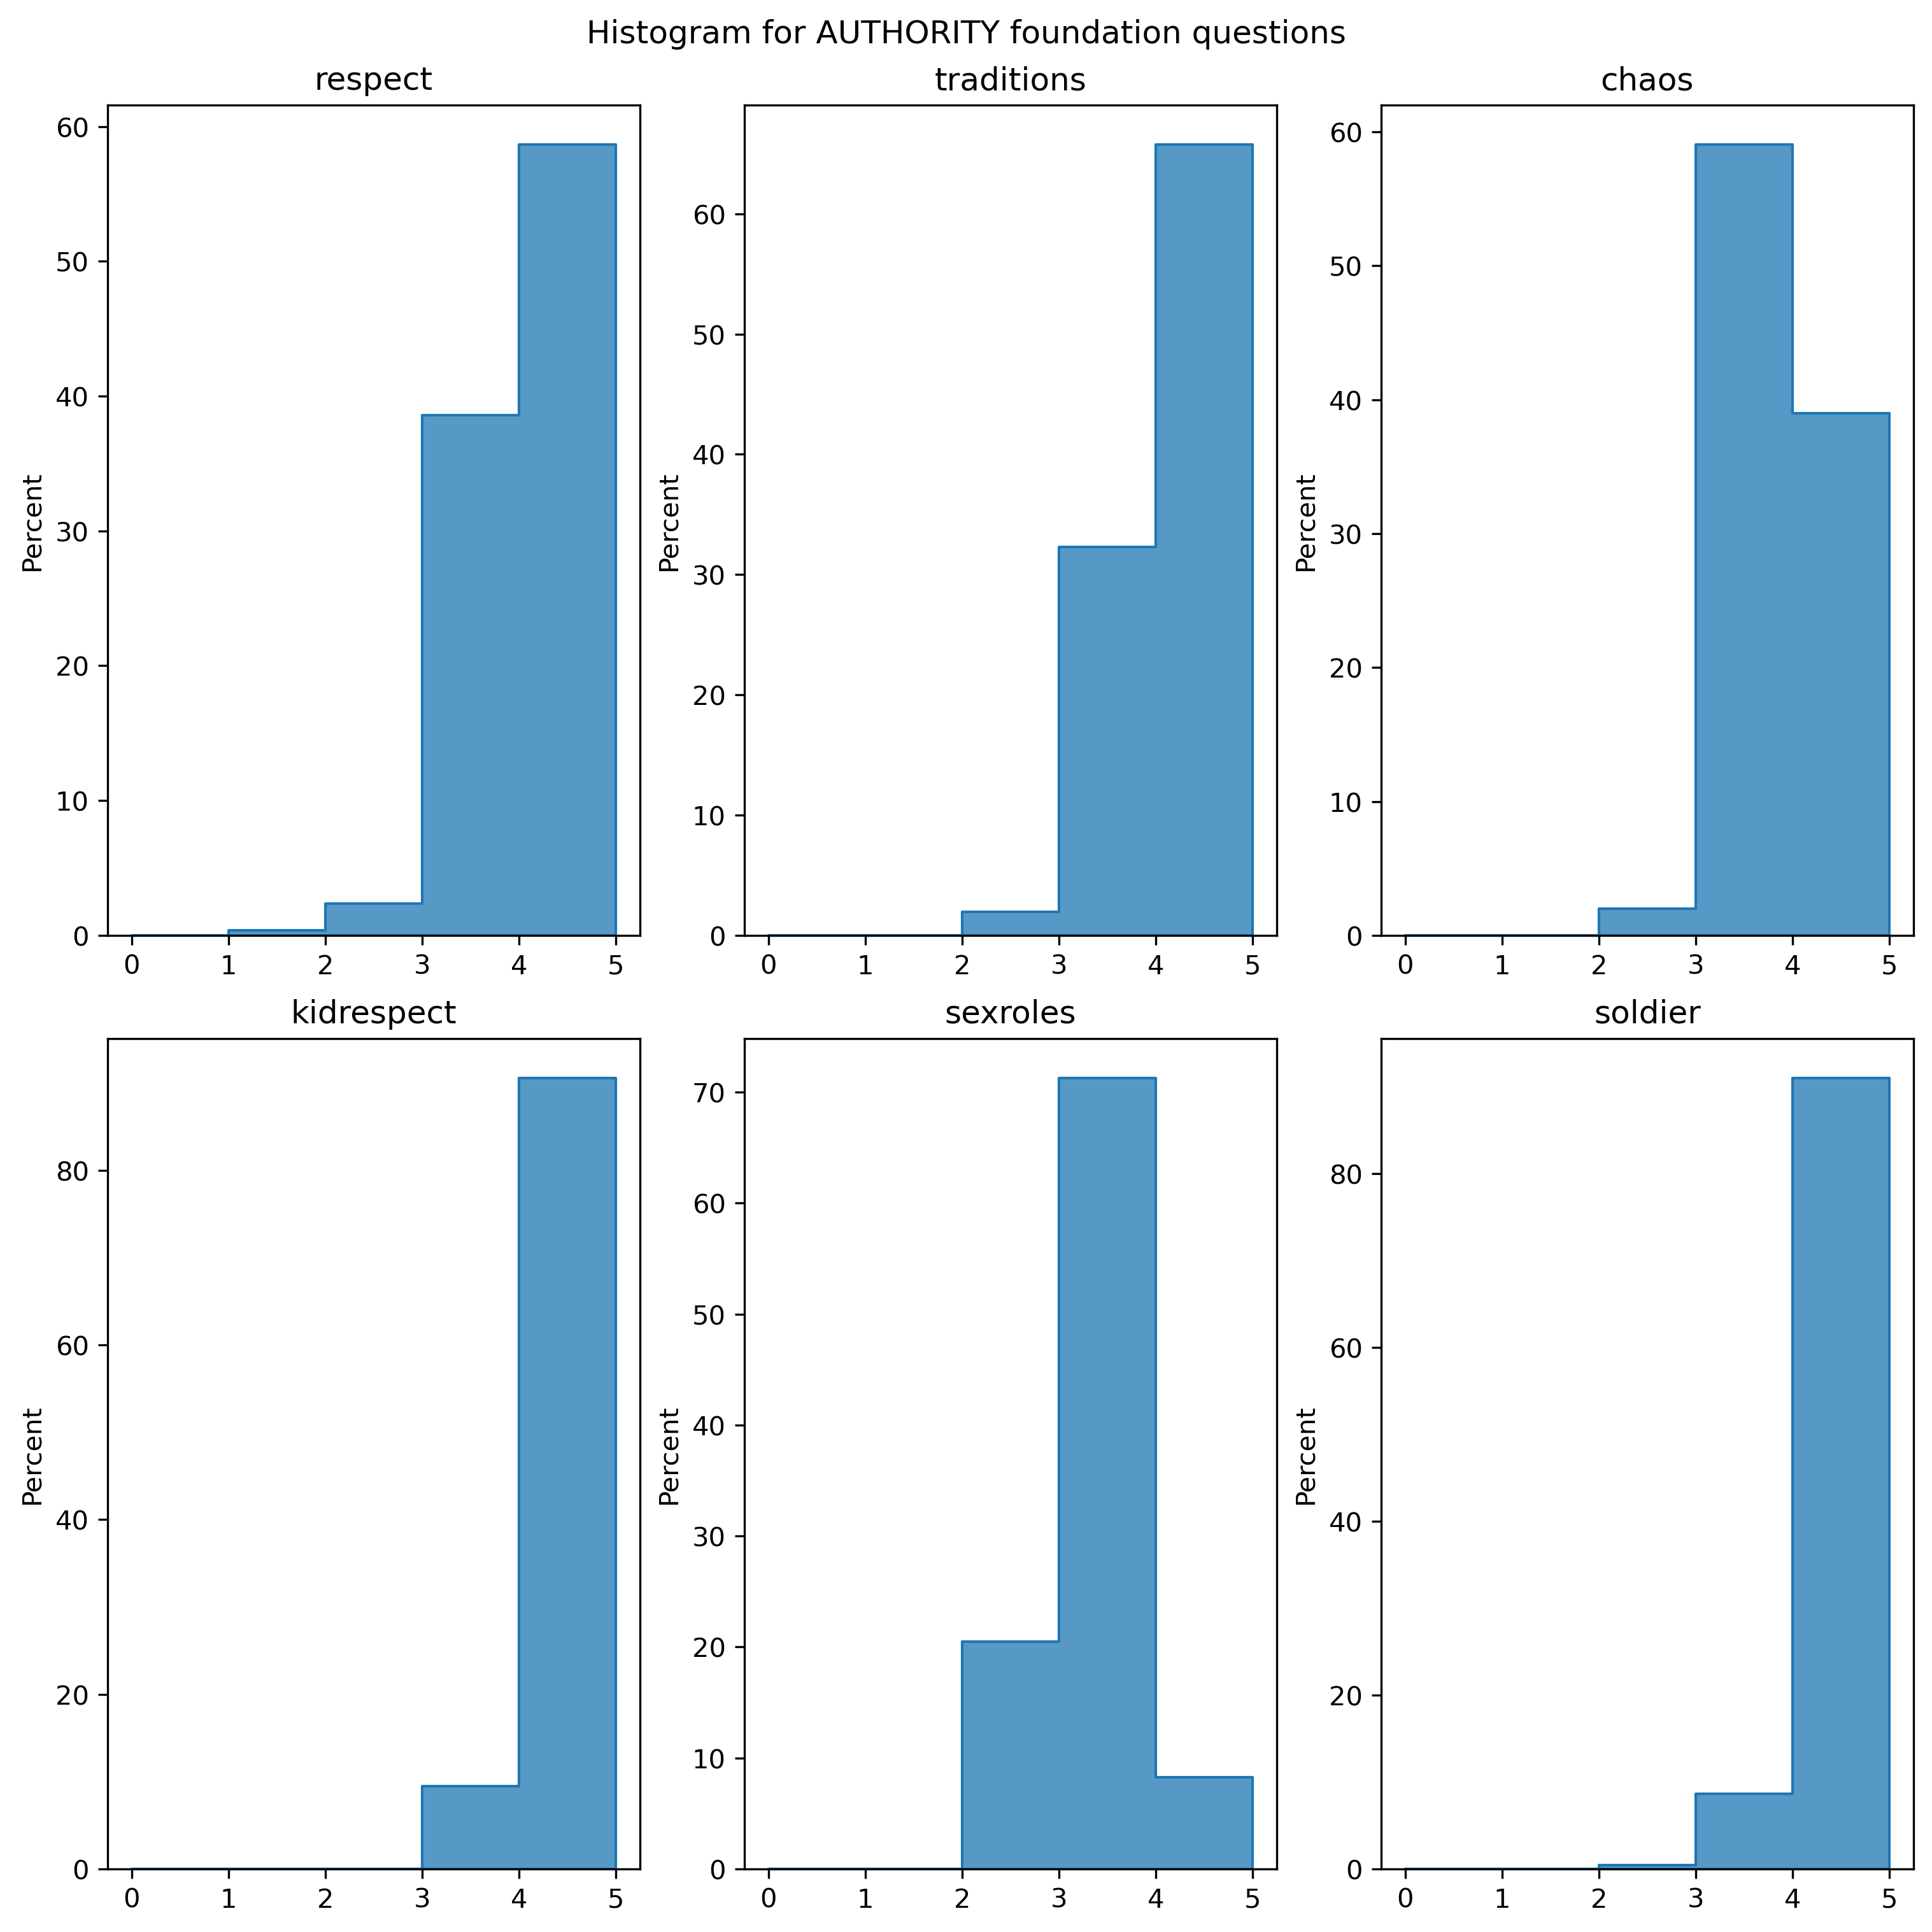

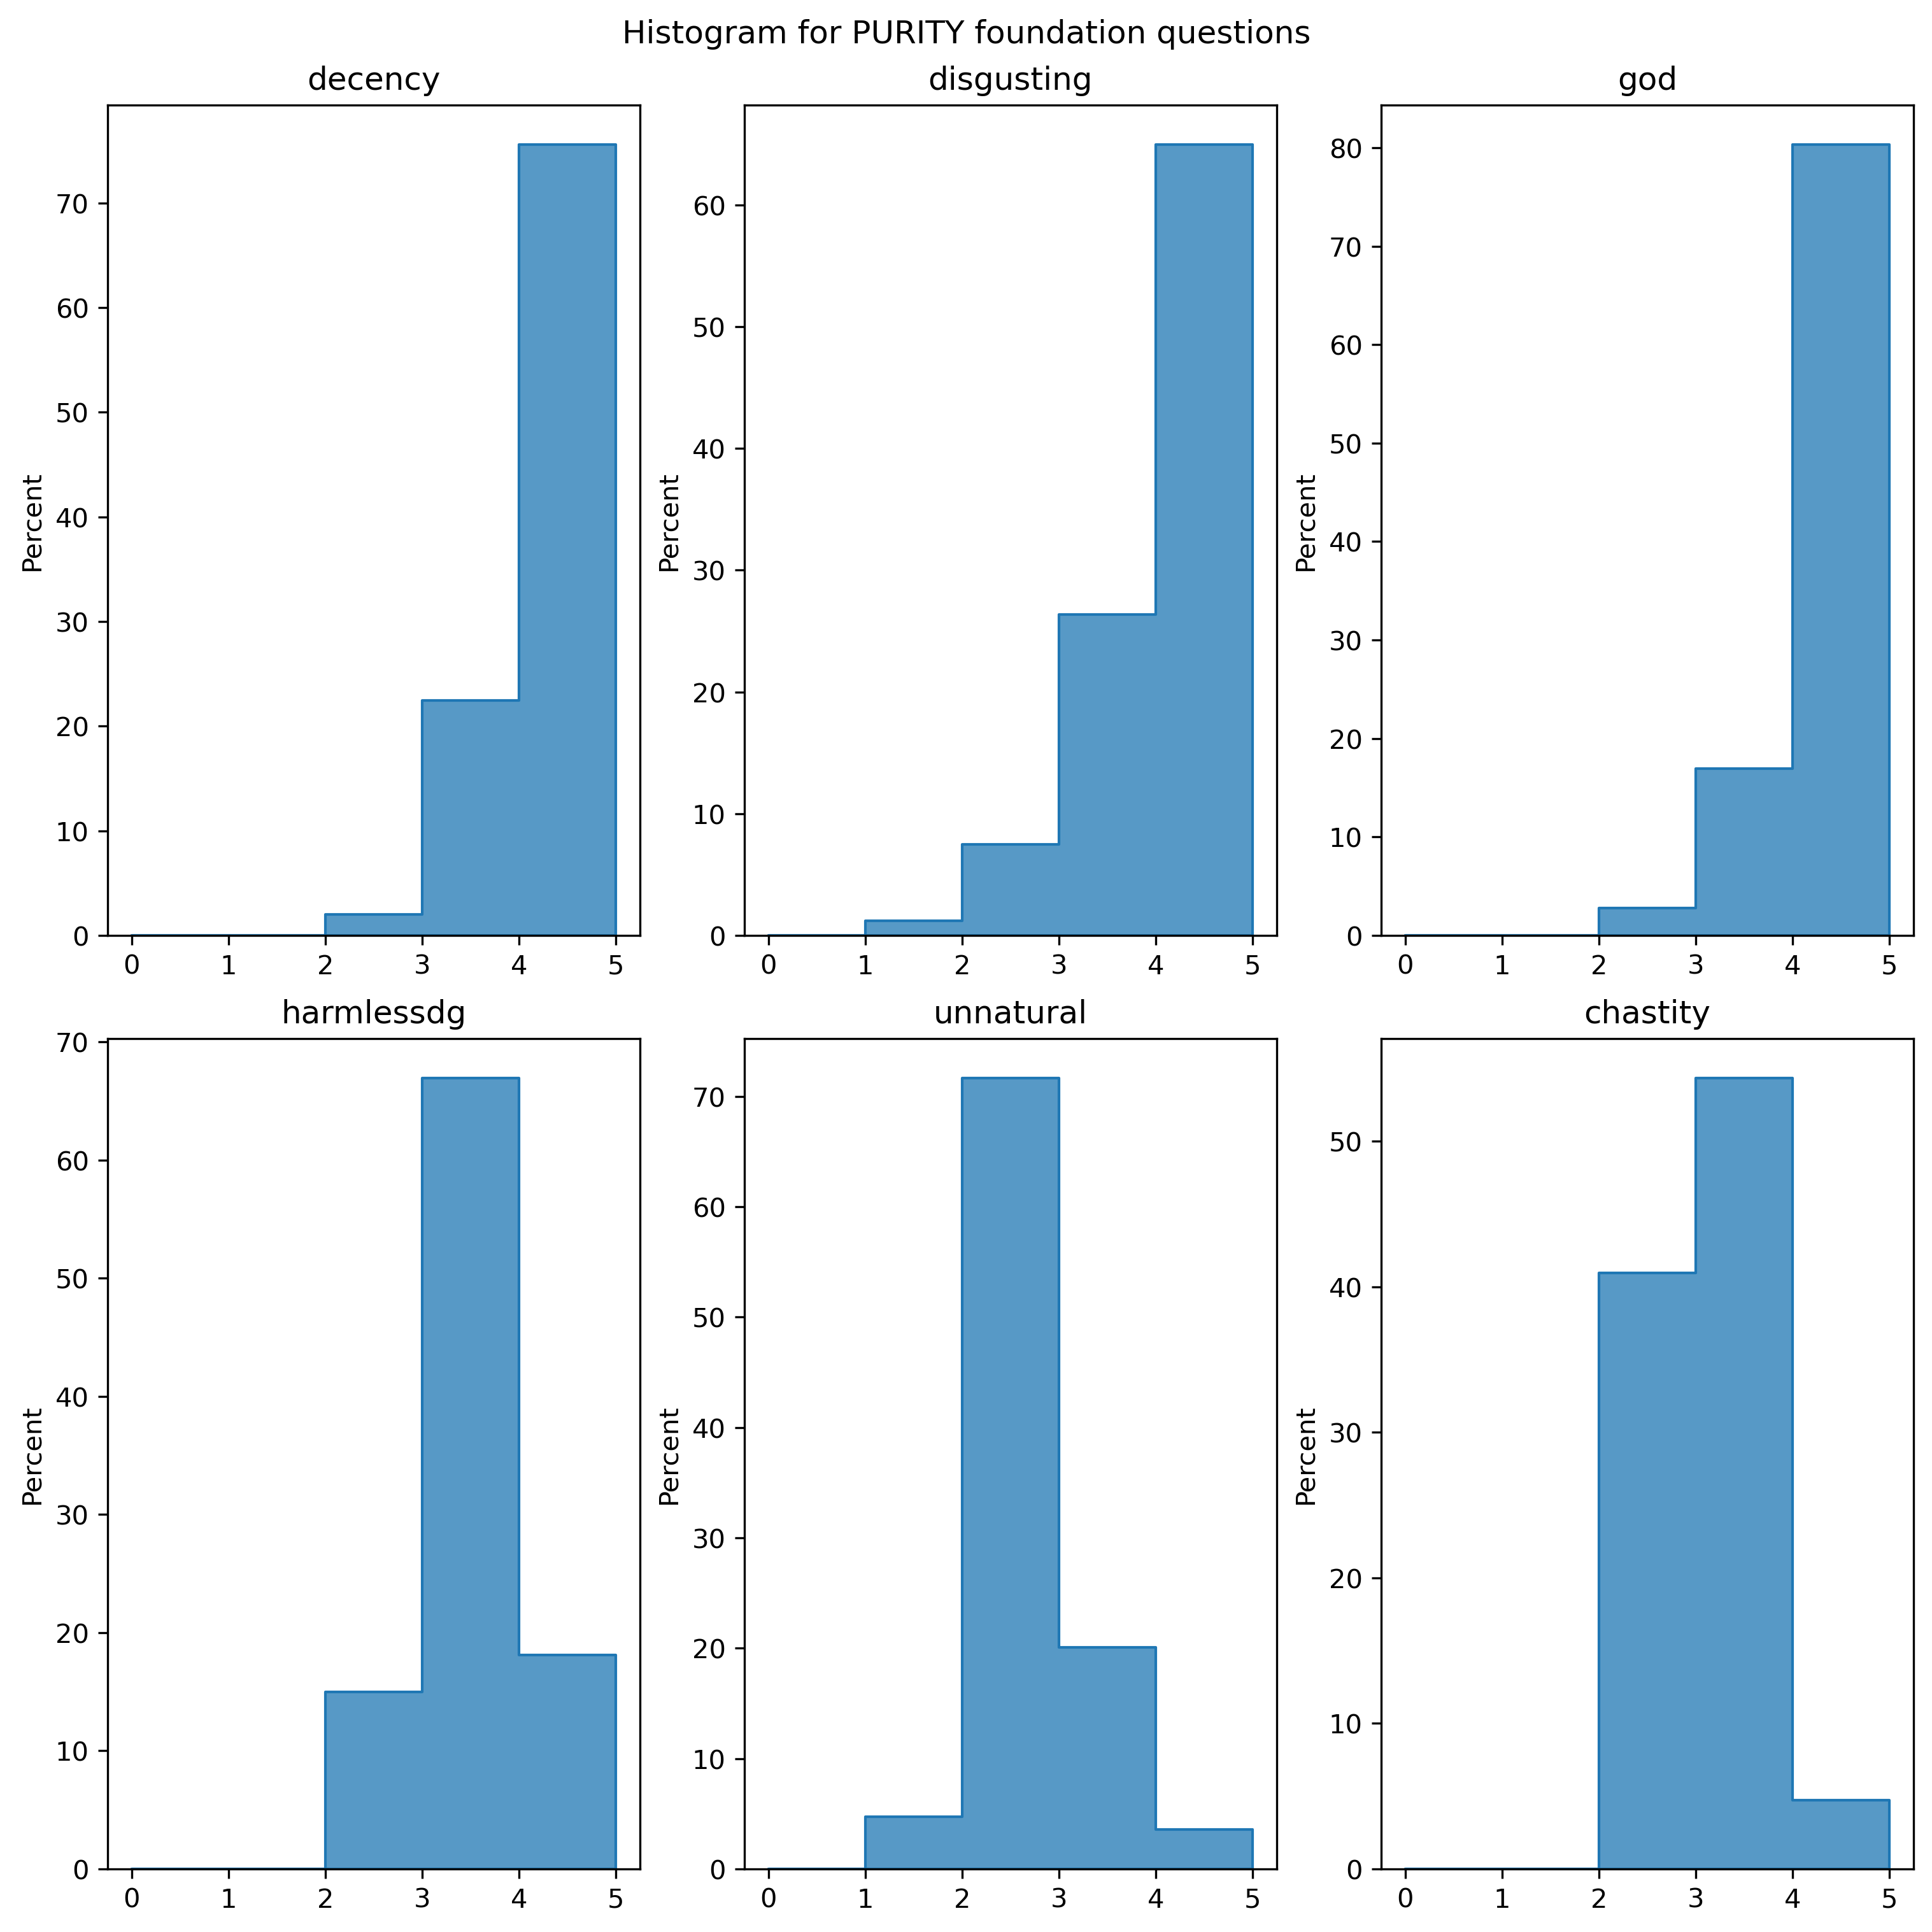

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
# create a histogram for each question in each foundation
for foundation, questions in questions_dict.items():
    fig, axs = plt.subplots(figsize=(10, 10), constrained_layout=True, dpi=300, nrows=2, ncols=3)
    plt.suptitle(f"Histogram for {foundation.upper()} foundation questions")
    for i, question in enumerate(questions):
        ax = axs[i // 3, i % 3]
        sns.histplot(
            data=df_chat,
            x=question,
            color="tab:blue",
            bins=[0,1,2,3,4,5],
            # palette="colorblind",
            # hue="condition",
            # multiple="layer",
            element="step",
            stat="percent",
            ax=ax,
            legend=False,
        )
        ax.set_xlabel("")
        ax.set_title(question)


# Calculate cronbach per foundation in MFV

Loading data to obtain foundation per vignette

In [18]:
from helpers import original_validated
x = original_validated.copy()

In [19]:
# replace 'Care (p,a)' with 'Care (p)' and 'Care (p,h)' with 'Care (p)'
original_validated["Foundation"] = original_validated["Foundation"].replace(
    {
        "Care (p,a)": "Care (p)",
        "Care (p,h)": "Care (p)",
    },
)

Calculate cronbach per foundation in MFVs

In [34]:
for f in original_validated["Foundation"].unique():
    codes = original_validated.query("Foundation == @f")["mfv_code"].astype(str).unique().tolist()
    print(f"Cronbach for {f.upper()}:", cronbach_alpha(df_chat[codes]))
    # cronbach before
    print(
        "Before condition:",
        cronbach_alpha(df_chat.query("condition == 'before'")[codes])
    )
    # after
    print(
        "After condition:",
        cronbach_alpha(df_chat.query("condition == 'after'")[codes])
    )
    # also add mean to df_chat
    df[f"MFV_{f.title()}"] = df_chat[codes].mean(axis=1)
    

Cronbach for CARE (E): (0.832471581613244, array([0.8  , 0.861]))
Before condition: (0.7421808750109193, array([0.671, 0.804]))
After condition: (0.9055607220243465, array([0.879, 0.928]))
Cronbach for CARE (P): (0.8531155694122498, array([0.824, 0.879]))
Before condition: (0.9010384235009707, array([0.873, 0.925]))
After condition: (0.7851285936494312, array([0.724, 0.837]))
Cronbach for FAIRNESS: (0.8136157743870661, array([0.777, 0.846]))
Before condition: (0.8234856647615477, array([0.774, 0.866]))
After condition: (0.7981196501877893, array([0.74 , 0.847]))
Cronbach for LIBERTY: (0.9258053000167105, array([0.911, 0.939]))
Before condition: (0.941376430675167, array([0.925, 0.956]))
After condition: (0.8885622443015783, array([0.856, 0.916]))
Cronbach for AUTHORITY: (0.8822714256880221, array([0.859, 0.903]))
Before condition: (0.8675798090358472, array([0.831, 0.899]))
After condition: (0.8904935224832292, array([0.859, 0.917]))
Cronbach for LOYALTY: (0.9519829746547509, array([0.

# Regressing MFV mean per foundation on MFQ foundation mean

In [21]:
df.columns

Index(['id', 'condition', 'MFQ_harm', 'MFQ_fairness', 'MFQ_ingroup',
       'MFQ_authority', 'MFQ_purity', 'MFV_Care (E)', 'MFV_Care (P)',
       'MFV_Fairness', 'MFV_Liberty', 'MFV_Authority', 'MFV_Loyalty',
       'MFV_Sanctity'],
      dtype='object')

Standardizing variables

In [22]:
# standardize the scores
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[df.columns[2:]] = scaler.fit_transform(df[df.columns[2:]])

In [23]:
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

In [24]:
formula = "Q('{}') ~ MFQ_harm + MFQ_fairness + MFQ_ingroup + MFQ_authority + MFQ_purity"

independents = [x for x in df.columns if x.startswith("MFV_")]

Running models

In [25]:
models = list()

for i in independents:
    mod = smf.ols(formula=formula.format(i), data=df)
    res = mod.fit()
    models.append(res)

output = summary_col(models, stars=True)

In [26]:
print(output)


               Q('MFV_Care (E)') Q('MFV_Care (P)') Q('MFV_Fairness') Q('MFV_Liberty') Q('MFV_Authority') Q('MFV_Loyalty') Q('MFV_Sanctity')
-------------------------------------------------------------------------------------------------------------------------------------------
Intercept      -0.0000           -0.0000           -0.0000           0.0000           0.0000             0.0000           -0.0000          
               (0.0629)          (0.0626)          (0.0628)          (0.0629)         (0.0632)           (0.0625)         (0.0619)         
MFQ_harm       -0.0266           -0.1494**         -0.0830           -0.1159*         -0.0767            -0.1636**        -0.1134*         
               (0.0677)          (0.0675)          (0.0677)          (0.0677)         (0.0681)           (0.0673)         (0.0667)         
MFQ_fairness   -0.0498           0.1278*           -0.0520           0.0211           -0.0129            0.1325**         0.2025***        
               (0.0

# Trying to run on factors

In [27]:
from helper_factor_analysis import run_factor_analysis

In [28]:
codes_vignettes = original_validated["mfv_code"].astype(str).unique()

Saving factor loading to investigate its coherence.

Saving was commented to run some visual highlighting on excel file.

ML method takes a couple dozen seconds to run

In [29]:
factor_df, factor_model = run_factor_analysis(df_chat[codes_vignettes], n_factors=7, method="ml", return_model=True)

# factor_df.to_excel(f"data/final/factor_analysis_{model}.xlsx")

KMO: 0.8798719718710555


/Users/lewis/miniconda3/envs/eda/lib/python3.11/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


Cumulative variance explained by 7 factors: 0.5088965900570712
Variance: [0.11535462 0.10206244 0.07344675 0.06735398 0.05077308 0.05029866
 0.04960706]


In [30]:
factor_cols = [f"Factor_{i}" for i in range(1, 8)]
df_with_factors = pd.concat(
    [
        df.reset_index(drop=True),
        pd.DataFrame(
            factor_model.transform(df_chat[codes_vignettes]),
            columns=factor_cols,
        ),
    ],
    axis=1,
)

df_with_factors.head(2)


,id,condition,MFQ_harm,MFQ_fairness,MFQ_ingroup,MFQ_authority,MFQ_purity,MFV_Care (E),MFV_Care (P),MFV_Fairness,...,MFV_Authority,MFV_Loyalty,MFV_Sanctity,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5,Factor_6,Factor_7
0,1,before,-1.451116,-0.021183,-0.018449,-0.239678,-0.626107,-1.482611,-0.639314,-0.923982,...,-0.337484,-0.453367,-0.150422,-0.324591,-0.395480,-0.176510,0.109858,-1.482307,-0.177659,-1.133666
1,2,before,1.172254,-0.917932,0.650972,0.468208,0.380420,1.210228,0.460363,1.640951,...,0.351961,-1.706101,0.531851,-2.045656,0.658006,-0.597515,0.238944,0.704138,0.275874,0.742658


In [31]:
models = list()

for i in factor_cols:
    mod = smf.ols(formula=formula.format(i), data=df_with_factors)
    res = mod.fit()
    models.append(res)

output_factors = summary_col(models, stars=True)

print(output_factors)


               Q('Factor_1') Q('Factor_2') Q('Factor_3') Q('Factor_4') Q('Factor_5') Q('Factor_6') Q('Factor_7')
----------------------------------------------------------------------------------------------------------------
Intercept      0.0000        -0.0000       -0.0000       -0.0000       0.0000        -0.0000       -0.0000      
               (0.0619)      (0.0608)      (0.0613)      (0.0611)      (0.0588)      (0.0620)      (0.0602)     
MFQ_harm       -0.1446**     -0.1388**     -0.0908       -0.0815       0.0080        -0.0858       -0.1001      
               (0.0667)      (0.0655)      (0.0661)      (0.0658)      (0.0633)      (0.0668)      (0.0649)     
MFQ_fairness   0.1437**      0.0190        0.0154        0.1599**      -0.0788       0.1129*       0.0459       
               (0.0648)      (0.0637)      (0.0642)      (0.0640)      (0.0615)      (0.0649)      (0.0631)     
MFQ_ingroup    -0.0240       0.0047        0.1237*       -0.0151       -0.0712       0.0109    